In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
from IPython import display
import gym
import pandas as pd
import gym_minigrid

import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict, deque
import random
from sklearn.preprocessing import MinMaxScaler

from matplotlib.colors import Normalize
normalize_qs = Normalize(vmin = -1, vmax = 1)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
} 
</style>
""")

# Utils

In [2]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


def render(env, mode='rgb', ax=None, highlight=False):
    img = env.render(mode=mode, highlight=highlight)
    if ax is None:
        plt.imshow(img, interpolation='nearest')
    else:
        ax.imshow(img, interpolation='nearest')
    clear_output(wait=True)
    plt.pause(0.00001)


def draw_triangle(ax, p1=[1, 1], p2=[2, 2.5], p3=[3, 1], c='blue', alpha=0.3):
    X = np.array([p1, p2, p3])
    Y = [c, c, c]
    ax.scatter(X[:, 0], X[:, 1], s=0.001, color=Y[:])
    t1 = plt.Polygon(X[:3, :], color=Y[0], alpha=alpha)
    ax.add_patch(t1)


def draw_square(ax,
                lb_x,
                lb_y,
                size,
                alpha=1,
                l_color='green',  # left
                r_color='yellow',  # right
                b_color='red',  # down
                t_color='blue'):  # up
    tr_x = lb_x+size  # top right x
    tr_y = lb_y+size  # top right y

    md_x = lb_x + size/2  # middle x
    md_y = lb_y + size/2  # middle x

    width = 10

    md_x_plus = md_x + width/2
    md_x_minus = md_x - width/2

    md_y_plus = md_y + width/2
    md_y_minus = md_y - width/2

    colormap = cm.get_cmap('RdYlGn')

    color_right = colormap(r_color)
    color_down = colormap(b_color)
    color_left = colormap(l_color)
    color_up = colormap(t_color)

    draw_triangle(ax,[lb_x+2, md_y], [md_x_minus, md_y_minus+2],
                  [md_x_minus, md_y_plus-2], c=color_left, alpha=alpha)  # left
    draw_triangle(ax,[tr_x-2, md_y], [md_x_plus, md_y_minus+2],
                  [md_x_plus, md_y_plus-2], c=color_right, alpha=alpha)  # right
    draw_triangle(ax,[md_x, tr_y-2], [md_x_minus+2, md_y_plus],
                  [md_x_plus-2, md_y_plus], c=color_down, alpha=alpha)  # down
    draw_triangle(ax,[md_x, lb_y+2], [md_x_minus+2, md_y_minus],
                  [md_x_plus-2, md_y_minus], c=color_up, alpha=alpha)  # up

In [3]:
def plot_return(ax, returns, y_min, y_max, rolling_window=10):
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Return')
    ax.set_title('Return versus Episodes')
    ax.set_ylim(y_min, y_max)
    ax.plot(np.array(returns), linestyle='dashed', color='silver', lw=1.5)
    ax.plot(pd.Series(returns).rolling(window=rolling_window).mean().values, lw=2)

def plot_epsilon(ax, epsilon_history):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Epsilon')
    ax.set_title('Epsilon versus Episodes')
    ax.plot(epsilon_history)

def plot_q_value_func(ax, table, env, alpha = 1, img = None):
    df_table = pd.DataFrame(table).T.reset_index()
    df_table.columns = ['y', 'x', 'right', 'down', 'left', 'up']
    df_table = df_table.sort_values(by=['y','x'])
    df_table['lb_x'] = df_table['x']*32
    df_table['lb_y'] = df_table['y']*32

    df_table[['right', 'down', 'left', 'up']] = normalize_qs(df_table[['right', 'down', 'left', 'up']])
    if img is None:
        img = env.grid.render(tile_size=32)
    ax.imshow(img, interpolation='nearest')
    for row in df_table.itertuples():             
        draw_square(ax,
                    row[-2], # lb_x
                    row[-1], # lb_y
                    32, 
                    alpha=alpha, 
                    r_color=row[3], # right
                    b_color=row[4], # down
                    l_color=row[5], # left
                    t_color=row[6]) # up

# Wrappers

In [4]:
from gym.spaces import Discrete
from gym.spaces import Box
from gym_minigrid.minigrid import Goal


class RewardWrapper(gym.core.Wrapper):

    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        self.env.step_count += 1

        reward = 0
        done = False

        # Get the position in front of the agent
        fwd_pos = self.env.front_pos

        # Get the contents of the cell in front of the agent
        fwd_cell = self.env.grid.get(*fwd_pos)

        # Rotate left
        if action == self.env.actions.left:
            self.env.agent_dir -= 1
            if self.env.agent_dir < 0:
                self.env.agent_dir += 4

        # Rotate right
        elif action == self.env.actions.right:
            self.env.agent_dir = (self.env.agent_dir + 1) % 4

        # Move forward
        elif action == self.env.actions.forward:
            if fwd_cell == None or fwd_cell.can_overlap():
                self.env.agent_pos = fwd_pos
            if fwd_cell != None and fwd_cell.type == 'goal':
                done = True
                reward = 1
            if fwd_cell != None and fwd_cell.type == 'lava':
                reward = -2
                done = True

        # Pick up an object
        elif action == self.env.actions.pickup:
            if fwd_cell and fwd_cell.can_pickup():
                if self.env.carrying is None:
                    self.env.carrying = fwd_cell
                    self.env.carrying.cur_pos = np.array([-1, -1])
                    self.env.grid.set(*fwd_pos, None)

        # Drop an object
        elif action == self.env.actions.drop:
            if not fwd_cell and self.env.carrying:
                self.env.grid.set(*fwd_pos, self.env.carrying)
                self.env.carrying.cur_pos = fwd_pos
                self.env.carrying = None

        # Toggle/activate an object
        elif action == self.env.actions.toggle:
            if fwd_cell:
                fwd_cell.toggle(self.env, fwd_pos)

        # Done action (not used by default)
        elif action == self.env.actions.done:
            pass

        else:
            assert False, "unknown action"

        if self.env.step_count >= self.env.max_steps:
            done = True

        obs = self.env.gen_obs()
        reward += -0.001
        return obs, reward, done, {}

    def reset(self, random_start=False):
        # Current position and direction of the agent
        self.env.agent_pos = None
        self.env.agent_dir = None

        # Generate a new random grid at the start of each episode
        # To keep the same grid for each episode, call env.seed() with
        # the same seed before calling env.reset()
        self.env._gen_grid(self.env.width, self.env.height)

        # These fields should be defined by _gen_grid
        assert self.env.agent_pos is not None
        assert self.env.agent_dir is not None

        if random_start:
            self.env.agent_pos = (random.randint(1,self.env.width-2),random.randint(1,self.env.height-2))
            start_cell = self.env.grid.get(*self.env.agent_pos)
            while start_cell is not None:
                self.env.agent_pos = (random.randint(1,self.env.width-2),random.randint(1,self.env.height-2))
                start_cell = self.env.grid.get(*self.env.agent_pos)

        # Check that the agent doesn't overlap with an object
        start_cell = self.env.grid.get(*self.env.agent_pos)
        assert start_cell is None or start_cell.can_overlap()

        # Item picked up, being carried, initially nothing
        self.env.carrying = None

        # Step count since episode start
        self.env.step_count = 0

        # Return first observation
        obs = self.env.gen_obs()
        return obs

## Reinforcement Learning
Reinforcement learning (RL) tries to solve a sequential decision-making problem, which is usually modelled as a Markov decision process (MDP). RL is concerned with how to choose actions from situations to maximise some notion of a numerical reward signal. The reward signal is a measure of how good the performed action or sequence of actions was, and it is used to guide software agents to learn optimal behaviour in a given
situation. In RL, the idea of trial and error is central, since the agent is not instructed
which actions to take and has no prior knowledge of the task at hand. The agent aims to
discover the consequences of actions through experimentation. Sometimes an action may
not only have an impact on the agent’s current situation but may also have an impact on
the subsequent situations that the agent encounters. Thus, the aspect of delayed reward
signals is also an important concept, as the outcome of specific actions can be experienced
at a later time.

The environment is the world that is assigned to the agent. It can be set in the
physical world, or it can be in the form of a computer simulator. The latter is very popular
to use for testing RL algorithms as simulations can be run at accelerated speeds.
The environment characterises the task at hand by defining the actions available, the
outcome of an action taken in a given situation, and the reward signal function. The
current environmental situation is known as the state of the environment.
The agent begins by receiving the initial state of the environment. The agent reacts to
the state by sending an action to the environment; in return, the agent receives a new
state and reward. The action of the agent is based on the observation received and chosen
according to the agent’s policy, where the policy determines the behaviour of the agent.
The process of acting and receiving observations and rewards in return is recurrent. At
each iteration of this process, the agent adjusts its policy to receive more rewards.

<p align="center">
<img src="resources/agent_environment_interaction.png" width="400">
</p>

# Getting Started with OpenAI Gym

Gym is an open-source Python library for developing and comparing reinforcement learning algorithms by providing a standard API to communicate between learning algorithms and environments, as well as a standard set of environments compliant with that API. Since its release, Gym's API has become the field standard for doing this.

In the graph below the agent receives an observervation ($o_t$) and reward ($r_t$) from the enviroment and takes an action ($a_t$) on the enviroment at timestep $t$. Based on the action ($a_t$) the enviroment gives the agent back an  observeration ($o_{t+1}$) and reward ($r_{t+1}$) at timestep $t+1$ which puts the whole loop in motion again for the next timestep.

<!-- ![alt text](inkscape/basic_rl_1.png "Title") -->
<p align="center">
<img src="resources/basic_rl_1.png">
</p>

## API

The <a href ="https://gym.openai.com/docs/">Gym API</a> provides us with an easy interface into the various environments. Below we define the 2 attributes (action and observation space) and 3 methods (step, reset and render) of the Gym API that we'll be using throughout this notebook to interact with the Minigrid Gym environments. 

### Attributes
The most important attributes in the Gym API are the action space and observation space. These define how the agent can interact with the environment and the type of observation that can be expected from the environment.

`action space`
The action space defines the available actions that can be performed in the environment

`observation space`
The observation space defines the observation the evironment returns.



### Methods
`def step(action)` performs a step in the environment with the supplied action and returns an observation, reward, and if the episode has terminated. This is the method that performs and action ($a_t$) at timestep $t$  and returns the reward ($r_{t+1}$) and observation ($o_{t+1}$) at timestep $t+1$.

`def reset()` resets the environment.

`def render()` renders the environment.

### Wrappers
Sometimes the action space and observation space of an environment can be too complex for an agent to utilise. Wrappers are used to transform an environment in a modular way. Environment wrappers are used to transform an observation before returning it the agent or to transform actions before performing them in the environment. Environment wrappers can also be used to tranform or the reward function of the environment. 

You can think of a wrapper as a way to customise the observation ($o_t$) returned to the agent as well as the action ($a_t$) sent by the agent.

## Gym Minigrid 
[Gym Minigrid](https://github.com/maximecb/gym-minigrid) is a third party gym environment developed by Chevalier-Boisvert. Gym  Minigrid has various environments to choose from with different goals and difficulties. We will utilse this environment in the rest of the notebook. Some examples of available environments are:
<ol>
    <li>MiniGrid-Empty-8x8-v0</li>
    <li>MiniGrid-UnlockPickup-v0</li>
    <li>MiniGrid-DistShift1-v0</li>
    <li>MiniGrid-LavaCrossingS9N3-v0</li>
</ol>



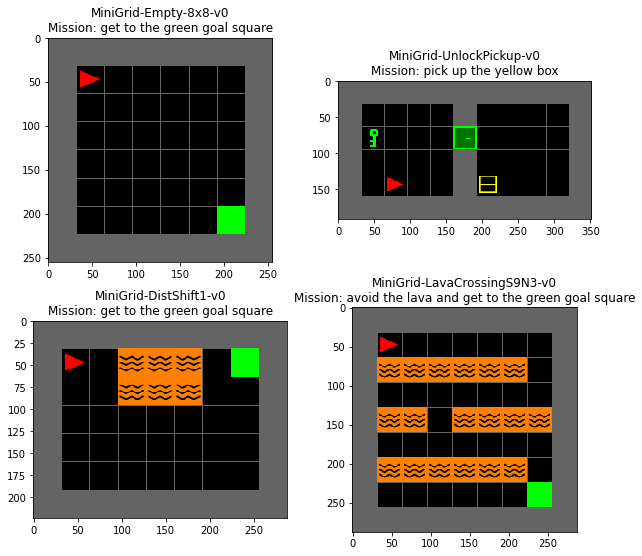

In [5]:
env_list = ['MiniGrid-Empty-8x8-v0',
            'MiniGrid-UnlockPickup-v0',
            'MiniGrid-DistShift1-v0',
            'MiniGrid-LavaCrossingS9N3-v0'
           ]

fig, axs = plt.subplots(2, 2, figsize=(10,7),)
plt.subplots_adjust(bottom=-0.1)
axs = axs.flatten()
for env_name, ax in zip(env_list, axs):
    env = gym.make(env_name) # create environment
    env.reset()
    img = env.render(mode='rgb', highlight=False)
    ax.imshow(img, interpolation='nearest')
    ax.set_title(env_name +'\nMission: ' + env.mission)
plt.show()

From the [Minigrid github page](https://github.com/maximecb/gym-minigrid), the default environments are defined as

Structure of the world:

+ The world is an NxM grid of tiles
+ Each tile in the grid world contains zero or one object
    + Cells that do not contain an object have the value None
+ Each object has an associated discrete color (string)
+ Each object has an associated type (string)
    + Provided object types are: wall, floor, lava, door, key, ball, box and goal
+ The agent can pick up and carry exactly one object (eg: ball or key)
+ To open a locked door, the agent has to be carrying a key matching the door's color

Actions in the basic environment:

+ Turn left
+ Turn right
+ Move forward
+ Pick up an object
+ Drop the object being carried
+ Toggle (open doors, interact with objects)
+ Done (task completed, optional)

Default tile/observation encoding:

+ Each tile is encoded as a 3 dimensional tuple: (OBJECT_IDX, COLOR_IDX, STATE)
+ OBJECT_TO_IDX and COLOR_TO_IDX mapping can be found in gym_minigrid/minigrid.py
+ e.g. door STATE -> 0: open, 1: closed, 2: locked


**In this notebook we will focus on basic environment where the goal of the agent is to get to the green goal while avoiding the lava. Let's create the 'MiniGrid-DistShift1-v0' environment and render it.**

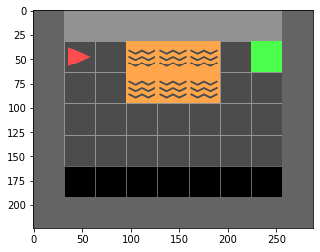

In [6]:
env_name = 'MiniGrid-DistShift1-v0'
env = gym.make(env_name) # create environment
env.reset() # reset the environment
render(env, highlight=True) # call helper function to render the environment in the notebook

Next we have a look at the observation space and action space of the environment. This is important since our agent will have to interperate the observations to choose actions to complete the task.

In [7]:
print(f'Observation space: {env.observation_space}') # observation space of the environment

Observation space: Dict(image:Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[25

The default observation the environment returns is of type `gym.spaces.Box`. It returns a numpy array with a shape of (7, 7, 3) with a minimum value of 0 and maxiumum value of 255. This represents and RGB image of the agent's field of view.

Let's view the action space of the environment.

In [8]:
print(f'Action space: {env.action_space}') # action space of the environment

Action space: Discrete(7)


The action space is of type `gym.spaces.Discrete`. The agent can perform an action with a discrete value between [0, 7).

As mentioned above, the 7 actions of the gym Minigrid environment are defined as follows:

<ol>
<li>Turn left</li>
<li>Turn right</li>
<li>Move forward</li>
<li>Pick up an object</li>
<li>Drop the object being carried</li>
<li>Toggle (open doors, interact with objects)</li>
<li>Done (task completed, optional)</li>
</ol>

To sample a random action from the action space call `env.action_space.sample()`. Let's use this function to perform random actions in the environment.

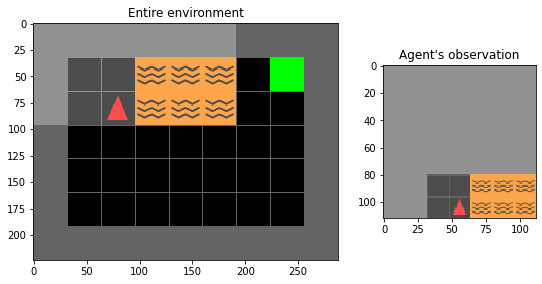

In [9]:
obs = env.reset() # reset and get an initial observation
action = 0

import time
for _ in range(100):
    action = env.action_space.sample() # sample a random action from the action space
    obs, reward, done, _ = env.step(action) # perform the action and receive an observation, reward, and if the episode is done
    
    # render the environment
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,10), gridspec_kw={'width_ratios': [2, 1]})
    ax1.set_title('Entire environment')
    ax2.set_title("Agent's observation")
    ax2.imshow(env.get_obs_render(obs['image']), interpolation='nearest') # render the agent's observation
    render(env, ax=ax1,highlight=True) # render the environment
    
    if done: # if the episode has terminated
        env.reset() # reset the environment

As our first (default) agent engages with the environment, we can see that the observation received by the agent is complex.The default Minigrid agent only receives partial information about it's "field of vision" which rendered on the right in the above simulation. It would be difficult to train an agent capable of solving this task using the current (partial) observation, instead we'll use environment wrappers to simplify the agent's observation and action space.

### Observation Wrapper that Returns Coordinates
We would rather like to use the agent's coordinates as observation since this will allow us to use tabular methods to solve this problem. Let's write an observation wrapper that returns the coordinates rather than the field of view of the agent. For this wrapper our class inherits from the `gym.core.ObservationWrapper` which is defined as:

```python
class ObservationWrapper(gym.core.ObservationWrapper):
    def reset(self, **kwargs):
        observation = self.env.reset(**kwargs)
        return self.observation(observation)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        return self.observation(observation), reward, done, info

    @abstractmethod
    def observation(self, observation):
        raise NotImplementedError
```

We have to implement the `observation` method. This method transforms the observation before returning it to the agent. We are just going to return the agent's coordinates instead of transforming the current observation. To achiev this, we'll use `self.agent_pos` to get the agent's $x$ and $y$ coordinates.

For completeness we also alter the observation space to respresent the observation that the environment returns. Previously this returned the entire image, but now we are only returning the coordinates of the agent. Note that we also structure our coordinate system as $y,x$ instead of $x,y$ as this works nicer with numpy arrays.

In [10]:
class CoordsObsWrapper(gym.core.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=np.array([0,0]), 
                                     high=np.array([env.height-3, env.width-3]),
                                     dtype=np.int32) # update the observation space       

    def observation(self, observation):
        return self.agent_pos[1], self.agent_pos[0] # return the y and x coordinates of the agent

### Action Wrapper

The default action space of the environment contains a few actions we do not need to solve the given task. We just need an agent that is able to traverse the grid world. To make things even simple we are going to ommit the actions that turns the agent and just have an agent that can move up, down, left and right. 

For this wrapper our class inherits from the `gym.core.ActionWrapper` which is defined as:

```python
class ActionWrapper(gym.core.ActionWrapper):
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        return self.env.step(self.action(action))

    @abstractmethod
    def action(self, action):
        raise NotImplementedError

    @abstractmethod
    def reverse_action(self, action):
        raise NotImplementedError
```

We have to implement the `action` function. This function transforms an action before performing it in the environment. One way to achieve this is to use the `self.agent_dir` attribute which is an integer value 1,2,3 or 4 which indicates the direction of the agent (up, down left or right). To match the `agent_dir` to the action we supplied (also a number 1,2,3 or 4) we let the agent step in the environment until it's direction is the action we would like.

In [11]:
class FourDirectionsActionWrapper(gym.core.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space = Discrete(4) # update the action space, the agent can only perform 4 different actions

    def action(self, action):
        while self.agent_dir != action: # turn the agent until it face the desired direction
            self.env.step(0)        
        return 2 # move forward in the current direction

### The Reward Function
We use a custom reward function in this notebook. The agent receives a reward of +1 if it gets to the green goal. We argued dying is worse than getting to the goal, therefore if the agent falls in the lava it receives a reward of -2. The agent receives an reward of -0.001 for each step it takes in the environment to incentivise it to complete the task as quickly as possible. We've include this wrapper in the notebook, so no need to implement it.
<p align="center">
<img src="resources/reward_function.png" width="450">
</p>

Let's apply the wrappers to the environment.

In [16]:
# Applying wrappers to the environment
env = RewardWrapper(env) # To receive the above defined rewards
env = CoordsObsWrapper(env) # wrapper that returns coordinates as observation
env = FourDirectionsActionWrapper(env) # wrapper that transforms action space to a four direction action space

Our new observation space:

In [19]:
print(f'Observation space: {env.observation_space}') # observation space of the environment
print(f'Random sampled observation: {env.observation_space.sample()}') # sample random observation

Observation space: Box([0 0], [4 6], (2,), int32)
Random sampled observation: [4 4]


The simplified action space:

In [20]:
print(f'Action space: {env.action_space}') # action space of the environment
print(f'Random sampled action: {env.action_space.sample()}') # sample random action

Action space: Discrete(4)
Random sampled action: 1


### Interacting with the environment

The agent in action after applying the wrappers.

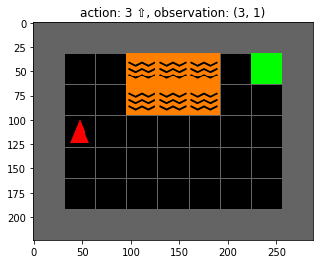

In [15]:
obs = env.reset() # reset and get an initial observation
action = 0
a_l = ['⇨','⇩','⇦','⇧']
import time
for _ in range(100):
    action = env.action_space.sample() # sample a random action from the action space
    obs, reward, done, _ = env.step(action) # perform the action and receive an observation, reward, and if the episode is done
    
    # render the environment
    fig, ax1 = plt.subplots()
    ax1.set_title(f'action: {action} {a_l[action]}, observation: {obs}')
    render(env, ax=ax1) # render the environment
    
    if done: # if the episode has terminated
        env.reset() # reset the environment

## Rewards and Returns

The goal of RL agent is described in terms of the reward signal that it receives at every time step.
The reward signal is a real number, $R_t \in \mathbb{R}$ and the objective of the agent is to maximise the sum of rewards received over time, i.e. the cumulative sum of rewards received in the course of its trajectory and not just the immediate reward.
The sum of all the rewards received during a trajectory in MDP is called the *return*, denoted with $G_t$.
In the simplest case, the return $G_t$ of a trajectory is the sum of rewards received after the time step $t$,
\begin{equation}
    G_t  \doteq R_{t+1} +  R_{t+2} + R_{t+3} + \dots+ R_T,
        % & = \sum_{k=0}^{T-1} \gamma^k R_{t+k+1},
\end{equation}
where $T$ is the final time step of the trajectory.

Next, we introduce the idea of discounting rewards.

By using a discounting rewards approach, the agent's objective is to choose actions in order to maximise the expected sum of discounted rewards.
Sutton and Barto define the discounted return $G_t$ as
\begin{equation}\label{eq:returndiscounted}
\begin{aligned}
    G_t & \doteq R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots \\
    & = \sum_{k=0}^\infty \gamma^k R_{t+k+1}.
\end{aligned}
\end{equation}
Gamma $\gamma \in [0,1]$ is the *discount rate* and determines the value of future rewards by scaling rewards based on the time step when it is acquired.
A value close to 0 favours rewards that are acquired in the near future, which leads to a *myopic* evaluation, whereas a value close to 1 assigns equal importance to all future rewards and leads to a more *far-sighted* evaluation.
Discounting rewards allows us to favour rewards based on the time they are received.
It also allows the return $G_t$ to be finite in tasks where $T=\infty$.
Note that there is a recursive relationship between returns at successive time steps
\begin{equation}\label{eq:recursivereturn}
    \begin{aligned}
    G_t & \doteq R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \gamma^3 R_{t+4} + \dots \\
    & = R_{t+1} + \gamma (R_{t+2}+\gamma R_{t+3} + \gamma^2 R_{t+4} + \dots)\\
    & = R_{t+1} + \gamma G_{t+1}.
    \end{aligned}
\end{equation}
This recursive relationship is fundamental to RL algorithms.

## Policies and Value Functions

In MDP the agent has to sequentially choose actions to accumulate rewards with the goal to receive the highest possible return.
Unfortunately a fixed sequence of actions will not solve MDP due to the uncertainty that is present in the transition model. 
The agent therefore needs to find a solution where each state in the MDP is mapped to a probability distribution that gives the probability of choosing each possible action.
Such a solution is described by Sutton and Barto as a stochastic rule which selects actions as a function of states, and is defined as policy $\pi$.
If the agent is following a policy $\pi$ at time step $t$, then $\pi(a|s)$ is the probability of taking the action $a$ given the state $s$.
The state-value function $v_\pi(s)$ is a way to evaluate the quality of a policy.
The state-value function $v_\pi(s)$ is the expected return $G_t$ if the agent is in state $s$ and then follows a policy $\pi$ and is defined by Sutton and Barto as
\begin{equation}\label{eq:statevalue}
\begin{aligned}
    v_\pi(s) & \doteq \mathbb{E}_\pi\left[G_t|S_t = s\right]\\
            &= \mathbb{E}_\pi\left[\sum_{k=0}^\infty \gamma^k R_{t+k+1}\middle|S_t = s\right], \text{ for all } s \in \mathcal{S}.
\end{aligned}
\end{equation}
The state-value function $v_\pi(s)$ is thus an estimate of how good it is to be in a given state.
The action-value function $q_\pi(s,a)$ is another way to evaluate a policy $\pi$. The action-value function $q_\pi(s,a)$ is the expected return $G_t$ if the agent is in state $s$, takes action $a$ and then follows policy $\pi$. Sutton and Barto define it as
\begin{equation}\label{eq:actionvalue}
\begin{aligned}
    q_\pi(s,a) & \doteq \mathbb{E}_\pi[G_t|S_t = s, A_t = a]\\
               &= \mathbb{E}_\pi\left[\sum_{k=0}^\infty \gamma^k R_{t+k+1}\middle|S_t = s, A_t = a\right].
\end{aligned}
\end{equation}
The action-value function $q_\pi(s,a)$ is therefore an estimate of how beneficial it is to perform a specified action in a given state and then following the policy $\pi$ afterwards.

## Monte Carlo Policy Evaluation

How do we determine how good a given policy is? We first discuss how Monte Carlo (MC) methods can be used for prediction or policy evaluation.
It has been shown by Sutton and Barto that if the agent follows a policy $\pi$ and encounters a state $s$, the average return that follows the state $s$  will converge to the state's value $v_\pi(s)$, as the number of times the state is visited approaches infinity. 
If an average is tracked for each action taken in the state $s$, then the state-action value $q_\pi(s,a)$ can similarly be determined.
These methods of estimating the value functions are called *Monte Carlo methods* because they entail averaging over many random sample episodes using the actual returns received.
As MC methods use samples of entire episodes for policy evaluation, the estimate of the value function is unbiased.
The drawback is that MC methods have to wait until the return $G_t$ is known.
Therefore values of states can only be updated at the end of an episode.

Each time a state $s$ is encountered we refer to it as a *visit* to $s$.
The first time the state $s$ is encountered, we refer to as the *first visit* to $s$.
There are two main MC policy evaluation methods to estimate $v_\pi$, namely the *first-visit* MC method and the *every-visit* MC method.
It has been shown by Sutton and Barto that the first-visit MC method estimates $v_\pi(s)$ as the mean return following the first visits to $s$.
On the other hand, the every-visit MC method estimates $v_\pi(s)$ as the mean return following all visits to $s$.
According to Sutton and Barto, first-visit MC and every-visit MC converge to $v_\pi(s)$ as the number of times $s$ is encountered, approaches infinity.
The result is an unbiased estimate of the expected value.

Next, we're going to implement first-visit MC policy evaluation to evaluate a random policy in the gridworld environment. Our agent is going to complete full episodes in the environment and we are going to average the return it receives from each state over all episodes.

In [21]:
import warnings
warnings.filterwarnings('ignore')

# TODO: Rather a class than a function?
def MCPE(episodes, env):
    returns = np.zeros((env.height, env.width)) # numpy array to keep track of the sum of returns received in state
    v_count = np.zeros((env.height, env.width)) # numpy array to keep track of the number of times a state has been visisted
    value_function = np.ones((env.height, env.width))*-2 # initialise value function

    for i in range(episodes):
        rewards = []
        states = []
        env.seed(1)
        state = env.reset()
        done = False

        while not done: # complete an episode and store the states and rewards
            states.append(state)
            state, reward, done, _ = env.step(env.action_space.sample())
            rewards.append(reward)

        G = 0 # set return to zero
        for state, reward in zip(states[::-1], rewards[::-1]): # loop over states and rewards in a reverse order
            states.pop() # pop the last state from the states list
            if state not in states: # check if the state does not appear earlier in the sequence
                G += reward # add the reward to the return
                v_count[state] += 1 # increment the number of times a first visit was made to this state
                returns[state] += G # add G to the total return received from this state

        # render plot        
        if (i+1) % 50 == 0:
            clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(8,5))
            ax = sns.heatmap(value_function, cmap='RdYlGn', alpha = 0.8, zorder=2, annot = True, fmt='.3f')
            img = env.grid.render(tile_size=32)
            ax.imshow(img,
                      aspect = ax.get_aspect(),
                      extent = ax.get_xlim() + ax.get_ylim(),
                      interpolation='nearest', zorder = 1)
            plt.pause(0.00001)

        value_function = np.round(returns/v_count, 3) # calculate the value function averaging the returns received in each state

    return value_function

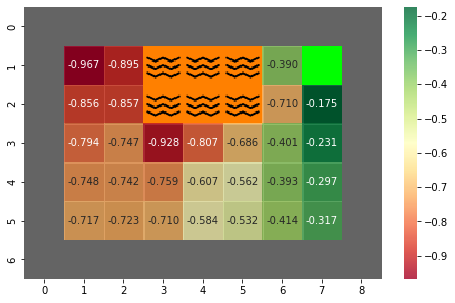

In [22]:
env = gym.make('MiniGrid-DistShift1-v0') # create environment
env = RewardWrapper(env) # wrap with reward wrapper
env = CoordsObsWrapper(env) # wrap to get coordinates of agent as observation
env = FourDirectionsActionWrapper(env) # wrap to simplify action space (4 directional movement)
value_function = MCPE(2000, env)

<font color='red'>ToDo: Discuss the generated plot above.</font>

## Policy Improvement
We now know how good it is to follow a random policy from each state in the environment. Next we would like to improve on this policy.
Using dynamic programming a model of the environment is required to perform a greedy policy improvement over a state-value function.
A greedy policy improvement over $v_\pi(s)$ is given by
\begin{equation}\label{eq:statevalueimprovement}
    \pi'(s) = \underset{a}{\text{argmax}} \sum_{s',r}p(s',r|s,a)\big[r+ \gamma v_\pi(s')\big].
\end{equation}
It is clear that the probabilities $p(s',r|s,a)$, which characterise the dynamics of the environment, are required to perform the policy improvement.
It is therefore impossible to use the state-value function for policies improvement steps in model-free settings.
In these applications, the action-value function is handy as it can be used to improve a policy without having access to the environment's model.
A greedy policy improvement over $q_\pi(s,a)$ is given by
\begin{equation}
    \pi'(s) = \underset{a}{\text{argmax }}q_\pi(s,a).
\end{equation}
We therefore use the action-value function in MC control in order to do policy improvements.

## ε-Greedy Exploration
Acting *greedily* with regard to the current estimated action-value function allows us to exploit our current knowledge of the system and allows for the maximisation of the expected reward on the current step.
By selecting nongreedy actions, alternative actions are explored and allow for improving the estimates of values of the nongreedy actions.
Alternative actions may be better than what current knowledge estimates to be best.
After discovering better actions, these can be exploited to produce greater reward in the long run.
There is, therefore, a conflict between exploration and exploitation as it is not possible to perform both with a single action.

MC methods use samples of experienced episodes to update value functions and to improve policies. 
Sufficiently exploring all possible state-action pairs with MC methods can be problematic.
By selecting only actions that are estimated to be the best, i.e. always performing greedy actions, alternative actions, which may be better, are never selected.
We must therefore ensure that the algorithm continues to explore alternative state-action pairs.
According to Sutton and Barto we can solve this problem by starting episodes with randomly sampled state-action pairs (with all state-action pairs having a none-zero probability of being sampled).
This guarantees that all state-actions pairs will be encountered an infinite number of times for an infinite number of episodes.
Sutton and Barto define the above assumption of randomly initialising state-action pairs at the start of an episode as *exploring starts*.
In simulated environments, exploring starts can often be implemented, but this method is usually not feasible to use with real-world problems.

An alternative way to address the problem of maintaining exploration is to have a stochastic policy that has a non-zero probability of selecting all possible actions in each state.
In applications where exploring starts cannot be used, the *$\varepsilon$-greedy* exploration strategy is convenient to use.
It is a very simple, effective exploration strategy that ensures continual exploration.
The $\varepsilon$-greedy strategy is defined as
\begin{equation}
    \pi(a|s) = \begin{cases} \varepsilon/|\mathcal{A}(S_t)| +1-\varepsilon &\text{if }a^* = \underset{a}{\text{argmax }}Q(s,a) \\
                        \varepsilon/|\mathcal{A}(S_t)| &\text{otherwise}
    \end{cases},
\end{equation}
where $|\mathcal{A}(S_t)|$ is the cardinality of the action space.
Every time the agent performs an action, it has a probability of $1-\varepsilon$ of selecting the greedy action, else (with a probability of $\varepsilon$) the action is randomly sampled.

### Implement ε-greedy exploration

Let's implement a simple function that performs $\varepsilon$-greedy exploration

``` python
def e_greedy(env, qtable, state, epsilon):
    pass
```


`random.random()` to obtain a random integer between 0 and 1

`env.action_space.sample()` to sample a random action from the environment

`np.armax(qtable[state])` to retreive the greedy action from the q-table 

In [24]:
def e_greedy(env, qtable, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(qtable[state])

## Monte Carlo Control

We are now going to use Monte Carlo estimation to perform control i.e. estimate an optimal policy to solve the task in the environment. We are going to use a concept referred to as generalised policy iteration (GPI). It entails storing an approximate policy and an an approximate value function. The value function is constantly updated to better approximate the current policy. The policy is again updated to be $\varepsilon$-greedy with respect to the value function. We therefore repeatedly make policy improvements. These two improvement kinds of changes work against each other to some extent, as each creates a moving target for the other, but together they cause both policy and value function to approach optimality.

<p align="center">
<img src="resources/monte_carlo_policy_iteration.png" width="450">
</p>

It is said that we do not have to precisely evaluate $q_\pi$, but only to move toward $q_\pi$. This will still converge to an optimal value function and an optimal policy.

<p align="center">
<img src="resources/monte_carlo_control.png" width="450">
</p>

We therefore only evaluate $q_\pi$ for one step at each iteration.

In [25]:
def get_epsilon(episode, eps_end=0.1, eps_start=1, eps_end_episode=300):
    return max(eps_end, 
                ((eps_end - eps_start) / eps_end_episode)*episode 
                + eps_start)

In [26]:
from collections import namedtuple, deque
transition = namedtuple('transition', 'state action')

def MC_Control_1(episodes, env, epsilon):
    q_table = defaultdict(lambda: np.zeros(shape=(env.action_space.n,)))
    returns = defaultdict(lambda: defaultdict(lambda: []))

    for ep in tqdm(range(episodes)):
        episode = []
        rewards = []
        env.seed(1)
        state = env.reset()
        done = False
        while not done:            
            action = e_greedy(env, q_table, state, get_epsilon(ep))
            episode.append((state, action))
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            state = next_state
            
        G = 0
        for (state, action), reward in zip(episode[::-1], rewards[::-1]):
            episode.pop() # pop the last state from the states list
            if (state, action) not in episode: # check if the state-action pair does not appear earlier in the sequence
                G += reward
                returns[state][action].append(G)
                q_table[state][action] = np.mean(returns[state][action])
            
#         # render
#         if ep % 100 == 0:
#             clear_output(wait = True)
#             fig, ax = plt.subplots()
#             plot_q_value_func(ax, q_table, env)
#             plt.pause(0.00001)
    return q_table

In [27]:
from collections import namedtuple
transition = namedtuple('transition', 'state action')

def MC_Control_2(episodes, env, epsilon):
    q_table = defaultdict(lambda: np.zeros(shape=(env.action_space.n,))) # initialise the q-table
    returns = defaultdict(lambda: np.zeros(shape=(env.action_space.n,))) # initialise returns
    visits = defaultdict(lambda: np.zeros(shape=(env.action_space.n,))) # initialise visits

    # for a number of episodes
    for ep in tqdm(range(episodes)): 
        episode = []
        rewards = []
        state = env.reset()
        done = False
        while not done: # perform episode and record states, actions and rewards           
            action = e_greedy(env, q_table, state, 0.1)
            episode.append((state, action))
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            state = next_state
            
        G = 0 # set return to zero
        # loop through episode in a reverse order
        for (state, action), reward in zip(episode[::-1], rewards[::-1]):
            episode.pop() # pop the last state-action pair from the episode list
            if (state, action) not in episode: # check if the state-action pair does not appear earlier in the sequence
                G += reward # add reward to the return
                returns[state][action] += G # add the return to the total returns received given this state-action pair
                visits[state][action] +=1 # increment the first visits to this state-action pair
                q_table[state][action] = returns[state][action]/visits[state][action] # update Q-value of state-action pair
        
    return q_table

In [28]:
env = gym.make('MiniGrid-Empty-8x8-v0') # create environment
env = RewardWrapper(env) # wrap with reward wrapper
env = CoordsObsWrapper(env) # wrap to get coordinates of agent as observation
env = FourDirectionsActionWrapper(env) # wrap to simplify action space (4 directional movement)
q_table = MC_Control_2(5000, env, epsilon=0.1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 186.74it/s]


The learned q-table is now demonstrated by performing the greedy action at each time step.

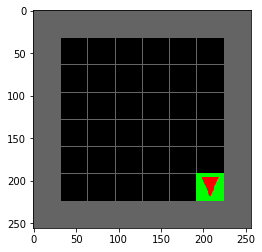

In [29]:
def demo(epsilon, env, qtable):
    done = False
    state = env.reset()
    for i in range(10):
        while not done:
            action = e_greedy(env, qtable, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            render(env)
        state = env.reset()
        done = False
        
demo(epsilon=0, env=env, qtable=q_table) # demonstrate the agent using an epsilon of zero

# Temporal-difference Control

Temporal-difference (TD) methods are central to RL and, like MC methods, can learn optimal policies and value functions from environmental interaction without the need for a model that describes the dynamics of the environment.
Unlike MC methods, these methods do not have to wait until the end of an episode before updating the value function and improving the policy.
They achieve this ability by using bootstrapping.
Bootstrapping entails updating estimated values based on other estimated values.
This allows them to be more effective in solving continuous tasks or tasks with long episodes, which are problematic for MC methods.

## The Bellman Equation

In this section we review the Bellman equation.
It can be used to break down the value function to describe the recursive relationship between a state's value and the values of the states that follow it.

The recursive relationship between successive returns can be used to decompose the expected return $G_t$ in as the expected immediate reward $R_{t+1}$ plus the expected discounted return at the next time step $\gamma G_{t+1}$.
The state-value function becomes
\begin{equation}\label{eq:bellmanstatevalue}
\begin{aligned}
    v_\pi(s) & \doteq \mathbb{E}_\pi[G_t|S_t = s]\\
    &= \mathbb{E}_\pi[R_{t+1} + \gamma G_{t+1}|S_t = s]\\
    &= \sum_a \pi(a|s) \sum_{s'}\sum_r p(s',r|s,a)\big[r +\gamma \mathbb{E}_\pi[G_{t+1}|S_{t+1} = s']\big]\\
    &= \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a)\big[r +\gamma v_\pi(S_{t+1})\big], \text{ for all } s \in \mathcal{S}\\
  &= \mathbb{E}_\pi\big[R_{t+1} + \gamma v_\pi(S_{t+1})|S_t = s\big].
\end{aligned}
\end{equation}
The expected discounted return $G_{t+1}$ is replaced with the discounted state-value function of the next state $\gamma v_\pi(S_{t+1})$.
The outer expectation becomes a summation over the variables $a$, $s'$, and $r$.
For each combination of the variables $a$, $s'$, and $r$, the probability $\pi(a|s)p(s',r|s,a)$ is computed.
The value between the brackets is weighted by each probability, then a sum over all possibilities is computed to get an expected value. 
This is known as the Bellman equation for $v_\pi$, and is named after Richard Bellman, who developed it in 1957.
It states that the value of a given state is equal to the discounted value of the expected next state plus the value of the expected received reward.
The action-value function can be similarly decomposed and gives
\begin{equation}\label{eq:bellmanactionvalue}
    q_\pi(s, a)= \mathbb{E}_\pi\big[R_{t+1} + \gamma q_\pi(S_{t+1}, A_{t+1})|S_t = s, A_t = a\big].
\end{equation}
The Bellman equation can be used to check for optimality and for recursive assignments during policy evaluation.

Next we are going to implement two TD agents. First we create a base class for these agents.

In [30]:
class Agent:
    """
    Base Agent class
    """
    def __init__(self,
                 env_name,
                 learning_rate=0.1,
                 eps_start = 1,
                 eps_end= 0.1,
                 eps_end_episode = 100,
                 episodes=1000,
                 gamma=0.95):
        
        self.env_name = env_name
        self.env = self.create_env(env_name)
        
        # decaying epsilon parameterisation
        self.eps_start = eps_start # epsilon start value
        self.eps_end = eps_end # epsilon end value
        self.eps_end_episode = eps_end_episode # episode to reach end value    
        
        self.learning_rate = learning_rate # agent learning rate
        self.gamma = gamma # discount rate
        self.episodes = episodes # number of episode to train agent
        self.q_table = defaultdict(lambda: np.zeros(shape=(self.env.action_space.n,))) # initialise q-table
        
        self.episode_return_history = [] # list to keep track of return received at each episode
        self.epsilon_history = [] # list to keep track of epsilon
        
    def get_epsilon(self, episode):
        """
        Returns epsilon given an episode. As the number of episodes increases, the epsilon value decreases.
        Epsilon decays until it reaches its specified minimum value.
        """
        return max(self.eps_end, 
                    ((self.eps_end - self.eps_start) / self.eps_end_episode)*episode 
                    + self.eps_start)
        
    def create_env(self, env_name):
        """
        Create and wrap the environment for the agent.
        """
        env = gym.make(env_name)
        env = RewardWrapper(env)
        env = CoordsObsWrapper(env)
        env = FourDirectionsActionWrapper(env)
        return env        

    def e_greedy(self, state, epsilon):
        """
        Epsilon-greedy exploration strategy.
        """
        if random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def train(self):
        """
        Method used to train the agent. Each type of agent should implement this.
        """
        raise NotImplementedError
        
    def log_metrics(self, episode_return, epsilon):
        """
        Method used to log the return and epsilon value at the end of each episode.
        """
        self.episode_return_history.append(episode_return)
        self.epsilon_history.append(epsilon)
        
    def plot(self):
        """
        Method used to visualise training.
        """
        clear_output(wait = True)   
        plt.figure(figsize=(15,10)) 
        ax1 = plt.subplot(2, 2, 1)
        ax2 = plt.subplot(2, 2, 2)
        ax3 = plt.subplot(2,1,2)
        reward_range = self.env.reward_range
        plot_return(ax1, self.episode_return_history, y_min=reward_range[0]*1.1, y_max= reward_range[1]*1.1)
        plot_epsilon(ax2, self.epsilon_history)
        plot_q_value_func(ax3, self.q_table, self.env)        
        plt.pause(0.000001)
        
    def demo_plot(self, state, pause):
        """
        Method used to visualise a demonstration of the learnt q-table.
        """
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]}) 
        img = self.env.render(mode='rgb', highlight=False)
        plot_q_value_func(ax1, self.q_table, self.env, alpha = 0.4, img = img)
        plt.ylim(-0.1, 1)
        
        ax2.set_ylabel('Q-Values')
        ax2.set_title('Q-Values')
        sns.barplot(x=['right', 'down', 'left', 'up'], y=self.q_table[state], ax = ax2)
        clear_output(wait = True)
        plt.pause(pause)

    def demo(self, epsilon, episodes=5, pause=0.1, random_start = True):
        """
        Method that demonstrates the learnt policy.
        """
        done = False
        self.env.seed(1)
        state = self.env.reset(random_start = random_start)
        for i in range(episodes):
            while not done:
                self.demo_plot(state, pause)
                action = self.e_greedy(state,epsilon)
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
            self.env.seed(1)
            state = self.env.reset(random_start = random_start)
            done = False

## SARSA (state, action, reward, state, action)
We now review a SARSA to obtain optimal value functions and optimal policies.
According to Sutton and  Barto, the idea of TD learning methods is that the approximate policy and approximate value function can interact with each other in such a way that they both move towards their optimal values.
The first part of this process is to estimate the value function to predict the returns of the current policy.
The second part is to improve the policy with regard to the estimated value function.

In this section, we review an on-policy TD control method, *SARSA*.
Again the action-value function $q_\pi$ is used instead of the state-value function $v_\pi$, as the former does not require a transition model of the environment to improve the policy.
The goal is to obtain an optimal action-value function $q_*$ and therefore also an optimal policy $\pi_*$.
We first discuss how a policy $\pi$ is evaluated, and then how the policy is improved.

Similarly to the previous section, we learn a value function from samples of experience.
Here state-action pair to state-action pair is considered, and the estimated values of state-action pairs are updated.
The estimated action-value $Q(S_t, A_t)$ is updated:
\begin{equation}
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \big[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \big].
\end{equation}
The update is done for non-terminal states, and if state $S_{t+1}$ is terminal then $Q(S_{t+1}, A_{t+1})$ is defined as zero.

The estimated action-value function $Q$ is then used to improve the policy.
An $\varepsilon$-greedy strategy can be used to choose the action $A_{t+1}$ from the state $S_{t+1}$ using the estimated action-value function $Q$.
The $\varepsilon$-greedy strategy acts mostly greedy with regard to the estimated action-value function but also explores nongreedy actions from time to time.
In every update $S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1}$ are present and these give rise to the name SARSA.
SARSA for on-policy control since the agent learns about the policy it is following.

### Implement the SARSA update step
```python
def update_sarsa(self, action, state, next_state, next_action, reward, done):
    pass
```
$\alpha$ -> `self.learning_rate`

$\gamma$ -> `self.gamma`

$R_{t+1}$ -> `reward`

$Q(S_t, A_t)$ -> `self.q_table[state][action]`

$Q(S_{t+1}, A_{t+1})$ -> `self.q_table[next_state][next_action]`

In [31]:
class AgentSarsa(Agent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def update_sarsa(self, action, state, next_state, next_action, reward, done):
        """
        SARSA update rule
        """
        # if the episode is done the estimate future return is zero
        v_estimate = 0 if done else self.gamma*self.q_table[next_state][next_action]      
        # update the q-table using the SARSA update rule
        self.q_table[state][action] += self.learning_rate*(
            reward + v_estimate - self.q_table[state][action])

    def train(self):
        """
        SARSA training loop
        """
        
        done = False
        state = self.env.reset() # reset the environment and retrieve the initial state
        action = self.e_greedy(state, self.get_epsilon(0)) # choose an initial action using e-greedy strategy

        episode_return = 0 # set the episode return to zero
        
        # for a number of episodes
        for ep in range(self.episodes):
            epsilon = self.get_epsilon(ep) # get the value of epsilon for the current episode
            # while the episode is not done
            while not done:
                # perform action in the environment and get the next state, reward, and if episode is done
                next_state, reward, done, _ = self.env.step(action) 
                episode_return += reward # add reward to the the episode return
                if not done: # if not done, choose a next action using the next state
                    next_action = self.e_greedy(next_state, epsilon)
                
                # update q-table using SARSA update rule
                self.update_sarsa(action, state, next_state,
                                  next_action, reward, done)
                state = next_state # set state equal to next state
                action = next_action # set action equal to next action
            # if episode is done
            state = self.env.reset() # reset the environment
            action = self.e_greedy(state, epsilon) # choose first action of new episode using e-greedy
            done = False # set done to false
            
            # log metrics and set episode return to zero
            self.log_metrics(episode_return, epsilon)
            episode_return = 0
            
            # refresh visualisation every 10 episodes
            if ep % 10 == 0:
                self.plot()

Next we train a SARSA agent using the SARSA update rule you've implemented.

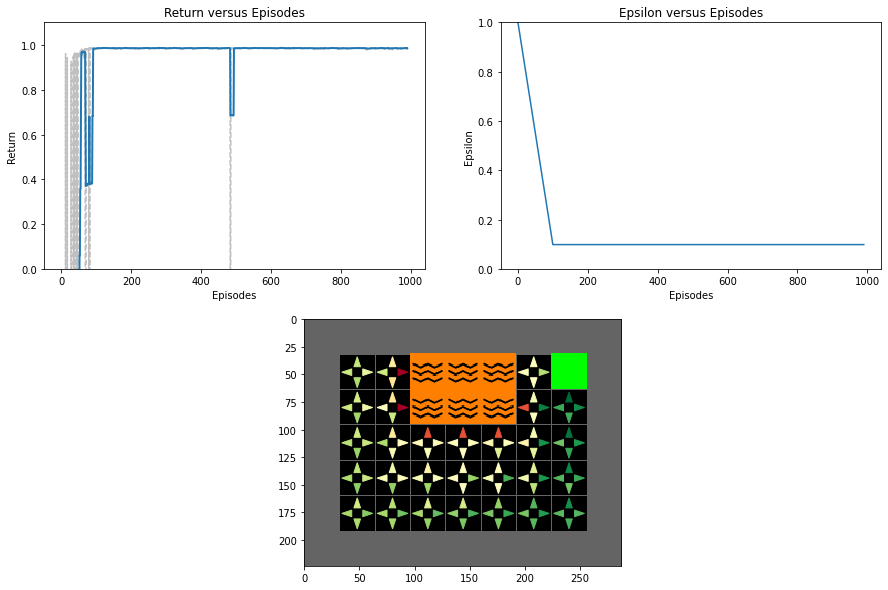

In [32]:
agent_sarsa = AgentSarsa(env_name='MiniGrid-DistShift1-v0') # create the SARSA agent
agent_sarsa.train() # train the agent

We've added some live plots to help you visualise the agent training.
The agent's learning curve is depicted in the upper-left plot. The return received by the agent is plotted against the number of episodes completed in this plot. A higher value indicates a more effective agent. The gray line indicates the actual return received at each episode, while the blue line is a rolling mean with window of 10 episodes.

The plot in the upper-right corner depicts the agent's epsilon value versus episodes. We used a decaying epsilon to train the agent.
This allows the agent to explore the environment at the beginning of training but to converge on an optimal policy by the end.

Finally, we used a heatmap to visualize the Q-values that the agent learned. Each state in the environment is represented by four arrows.
Green arrows represent high values, while red arrows represent lower Q-values. Following the dark green arrows, i.e. engaging in greedy behaviour, will complete the task. Let's put our agent's policy to the test!

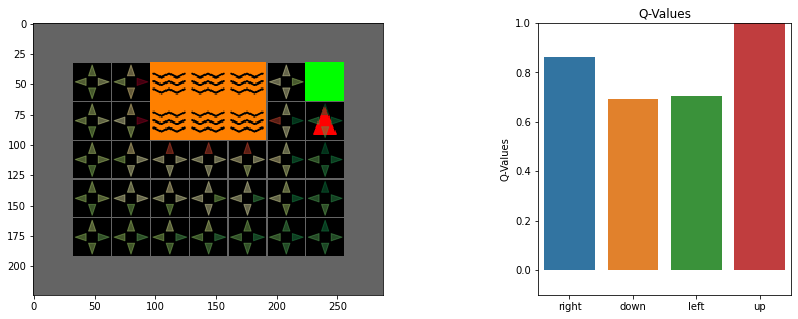

In [33]:
agent_sarsa.demo(0, pause =0.1, random_start=False)

The agent is acting greedily toward the Q-value function in this case. The Q-values for the four different actions for each state visited by the agent are shown in the barplot on the right. Our agent chooses the action with the highest value at each timestep. It is worth noting that takes a long path around the lava rather than the shortest path to the goal.

## Q-learning
<!-- <p align="center">
<img src="resources/q-learning.svg">
</p> -->
We now discuss second TD method referred to as Q-learning.
Q-learning is an off-policy TD method which Sutton and Barto describe as a breakthrough in RL.
It is classified as an off-policy method as the behaviour policy is independent of the target policy.
The target policy (the policy the agent learns about) is greedy with respect to $Q(s,a)$:
\begin{equation}
    \pi(S_{t+1}) = \underset{a}{\text{argmax}} Q(S_{t+1}, a).
\end{equation}
The Q-learning target can be simplified to
\begin{equation}
\begin{aligned}
    G_t & \approx R_{t+1} + \gamma Q\big(S_{t+1}, \underset{a}{\text{argmax}} Q(S_{t+1}, a)\big)\\
    &= R_{t+1} + \gamma \underset{a}{\max}  Q(S_{t+1}, a).
\end{aligned}
\end{equation}
The Q-learning update step is defined as
\begin{equation}
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \big[R_{t+1} + \gamma \underset{a}{\max} Q(S_{t+1}, a) - Q(S_t, A_t) \big].
\end{equation}
The behaviour policy can be anything, but it is usually $\varepsilon$-greedy with respect to $Q(s,a)$.
The behaviour policy can also take the form of experience generated by older policies or by expert demonstrators.
The off-policy nature of the algorithm allows it to be more sample-efficient as it can reuse previously generated experience to learn.
This also makes it possible to learn from several different policies at the same time.
Sutton and Barto state that with Q-learning, the estimate action-value function $Q$ converges to the optimal action-value function $q_*$ when all state-action pairs are infinitely updated.
In practice it is not necessary to converge all the way to $q_*$ to obtain an optimal policy $\pi_*$.

### Implement the Q-learning update step
Implement the Q-learning update step by using the following parameters.

```python
def update_q_table(self, action, state, next_state, reward, done):
    pass
```
$\alpha$ -> `self.learning_rate`

$R_{t+1}$ -> `reward`

$Q(S_t, A_t)$ -> `self.q_table[state][action]`

$\underset{a}{\max} Q(S_{t+1}, a)$ -> `np.max(self.q_table[next_state])`

In [34]:
class AgentQL(Agent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def update_qlearning(self, action, state, next_state, reward, done):
        """
        Q-learning update rule
        """
        # if the episode is done the estimate future return is zero
        v_estimate = 0 if done else self.gamma*np.max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate*(
            reward + v_estimate - self.q_table[state][action])

    def train(self):
        """
        Q-learning training loop
        """
        done = False
        state = self.env.reset()
        episode_return = 0
        
        # for a number of episodes
        for ep in range(self.episodes):
            epsilon = self.get_epsilon(ep) # get the value of epsilon for the current episode
            # while the episode is not done
            while not done:
                action = self.e_greedy(state, epsilon) # choose action using e-greedy strategy
                # perform action in the environment and get the next state, reward, and if episode is done
                next_state, reward, done, _ = self.env.step(action)
                episode_return += reward # add reward to episode return
                
                # update q-table using Q-learning update rule
                self.update_qlearning(action, state, next_state, reward, done)
                
                state = next_state # set state equal to next state
                
            # if episode is done
            state = self.env.reset()
            done = False
            
            # log metrics and set episode return to zero
            self.log_metrics(episode_return, epsilon)
            episode_return = 0
            
            # refresh visualisation every 10 episodes
            if ep % 10 == 0:
                self.plot()

Next we train an Q-learning agent using the update step you've implemented. 

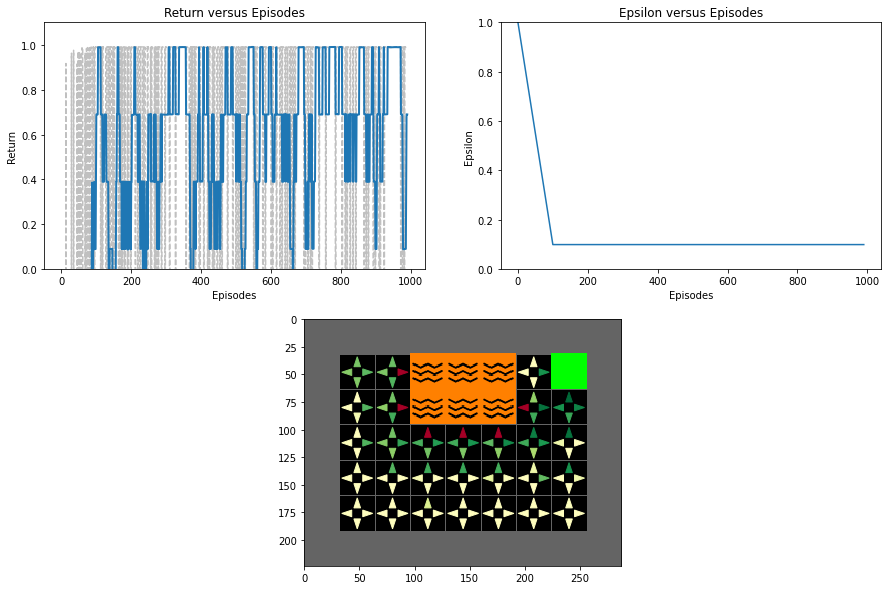

In [35]:
agent_q = AgentQL(env_name='MiniGrid-DistShift1-v0') # initialise the q-learning agent
agent_q.train() # train the agent

The same visualizations are used to monitor training. Take note of how the learning curve and Q-table heatmap differ from those of the SARSA agent. What's the reason for this?

Following that, we demonstrated the policy that our Q-learning agent had learned.

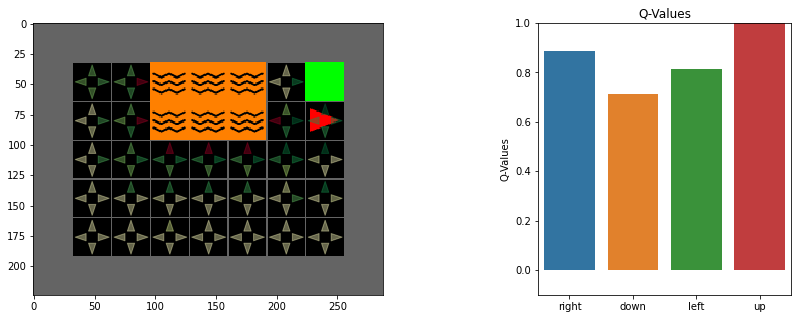

In [36]:
agent_q.demo(0,pause=0.05, episodes=10, random_start=False)

Compare the policy of the Q-learning agent with the one of the SARSA agent. How do they differ and what is the reason the difference? How can we train a SARSA agent that behaves more like the Q-learning agent?

Let's plot the distribution of returns received by the SARSA and Q-learning agent's during training.

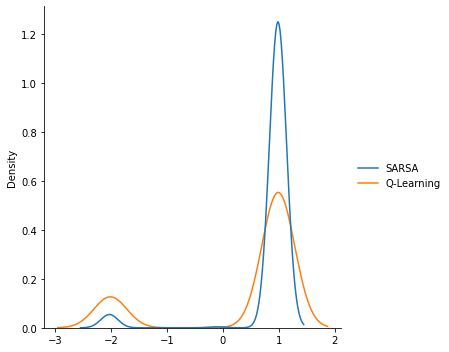

In [37]:
dis_df = pd.DataFrame({'SARSA': agent_sarsa.episode_return_history, 'Q-Learning': agent_q.episode_return_history})
sns.displot(dis_df, kind='kde')
plt.show()

From the above plot it seems that the SARSA agent performs better during training. Why is this the case?

Finally, we can apply this agent to some of the other environments as well. Some of the environments initialise differently each time they are reset. For these environments just call `env.seed(1)` to train in the exact same environment each episode.

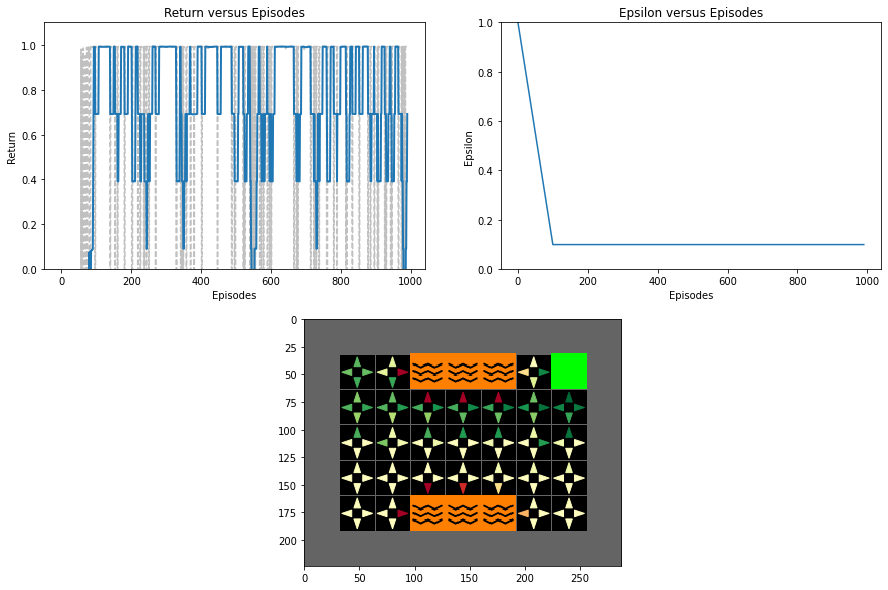

In [38]:
agent_q = AgentQL(env_name='MiniGrid-DistShift2-v0')
agent_q.train()